# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, I will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. I will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. I will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

Before looking at the bike sharing data, I will start by asking questions you might want to understand about the bike share data. What kinds of information would you want to know about in order to make smarter business decisions? If you were a user of the bike-share service, what factors might influence how you would want to use the service?


Here are the things to consider and possibly solved by exploring the data:
1. Who is using the bikeshare systems?
2. When do they use it (time of day/time of year/season/weather patterns)?
3. Where do they use it?  Pick up and drop off locations?
4. What are the demographics of each user?
5. What is the most common trip duration?
6. Are there any factors of the environment that would affect trip duration?



<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly.



In [4]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.
import pandas as pd # converts CSV files
import numpy as np # performs calcs
import matplotlib as mpl 

In [5]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## TODO: Use the csv library to set up a DictReader object. ##
        ## see https://docs.python.org/3/library/csv.html           ##
        trip_reader = csv.DictReader(f_in)
        
        ## TODO: Use a function on the DictReader object to read the     ##
        ## first trip from the data file and store it in a variable.     ##
        ## see https://docs.python.org/3/library/csv.html#reader-objects ##
        first_trip = next(trip_reader)
        
        ## TODO: Use the pprint library to print the first trip. ##
        ## see https://docs.python.org/3/library/pprint.html     ##
        pprint(first_trip)
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

I have generated new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. 
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two.


In [6]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.

    """
    
    if city == 'NYC':
        duration = int(datum['tripduration'])/60
    elif city =='Chicago':
        duration = int(datum['tripduration'])/60
    else:
        duration = int(datum['Duration (ms)'])/1000/60
        
    return duration


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [7]:
import datetime
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    
    HINT: You should use the datetime module to parse the original date
    strings into a format that is useful for extracting the desired information.
    see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    """
    weekday_dictionary = {0: "Monday",
                          1: "Tuesday",
                          2: "Wednesday",
                          3: "Thursday",
                          4: "Friday",
                          5: "Saturday",
                          6: "Sunday"}
    
    
    if city == 'NYC':
        
        #get month
        month = datum['starttime'].split('/')[0]
        
        #get hour
        hour = datum['starttime'].split()[1].split(':')[0]
        
        #get day of week
        month, day, year = datum['starttime'].split('/')[0],datum['starttime'].split('/')[1],datum['starttime'].split('/')[2].split()[0]
        week_day = datetime.datetime.weekday(datetime.date(int(year),int(month),int(day)))
        day_of_week = weekday_dictionary[week_day]
        
        
    elif city == 'Chicago':
        
        #get month
        month = datum['starttime'].split('/')[0]
        
        #get hour
        hour = datum['starttime'].split()[1].split(':')[0]
        
        #get day of week
        month, day, year = datum['starttime'].split('/')[0],datum['starttime'].split('/')[1],datum['starttime'].split('/')[2].split()[0]
        week_day = datetime.datetime.weekday(datetime.date(int(year),int(month),int(day)))
        day_of_week = weekday_dictionary[week_day]
        
    else:
        
        #get month
        month = datum['Start date'].split('/')[0]
        
        #get hour
        hour = datum['Start date'].split()[1].split(':')[0]
        
        #get day of week
        month, day, year = datum['Start date'].split('/')[0],datum['Start date'].split('/')[1],datum['Start date'].split('/')[2].split()[0]
        week_day = datetime.datetime.weekday(datetime.date(int(year),int(month),int(day)))
        day_of_week = weekday_dictionary[week_day]

        
        
    return (int(month), int(hour), day_of_week)


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [2]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """
    
    user_type_dictionary = {"Registered":"Subscriber",
                            "Casual":"Customer"}
    
    if city == 'NYC': user_type = datum['usertype']
    elif city == 'Chicago': user_type = datum['usertype']
    else: user_type = user_type_dictionary[(datum['Member Type'])]
    
    return user_type



tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

In [9]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    
    HINT: See the cell below to see how the arguments are structured!
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## TODO: set up csv DictReader object ##
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}
            
            month, hour, day_of_week = time_of_trip (row,city)
            new_point[out_colnames[0]] = round(duration_in_mins(row, city),2)
            new_point[out_colnames[1]] = month
            new_point[out_colnames[2]] = hour
            new_point[out_colnames[3]] = day_of_week
            new_point[out_colnames[4]] = type_of_user(row, city)

            ## TODO: use the helper functions to get the cleaned data from  ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            

            ## TODO: write the processed information to the output file.     ##
            ## see https://docs.python.org/3/library/csv.html#writer-objects ##
            
            trip_writer.writerow(new_point)

In [10]:
# Run this cell to check your work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.12'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.43'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.98'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now that I have the data collected and wrangled, I am ready to start exploring the data. In this section I will write some code to compute descriptive statistics from the data. I will also introduce the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the example Bay Area data in the `/examples/` folder.

Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?
 
1. Highest number of trips: NYC
2. Highest proportion of trips by subscribers: NYC
3. Highest proportion of trips by short term customers: Chicago

In [11]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total)

In [12]:
#Condensing and outputting all data in one run

filepaths = ['./data/NYC-2016-Summary.csv', 
             './data/Chicago-2016-Summary.csv', 
             './data/Washington-2016-Summary.csv']

for path in filepaths:
    print(path,":")
    n_subscribers, n_customers, n_total = number_of_trips(path)
    print("n_subscribers: ", n_subscribers)
    print("n_customers: ", n_customers)
    print("n_total: ", n_total)
    print("proportion subscribers: ", round(((n_subscribers/n_total)*100),1),"%")
    print("proportion customers: ", round(((n_customers/n_total)*100),1),"%")
    print("\n")

./data/NYC-2016-Summary.csv :
n_subscribers:  245896
n_customers:  30902
n_total:  276798
proportion subscribers:  88.8 %
proportion customers:  11.2 %


./data/Chicago-2016-Summary.csv :
n_subscribers:  54982
n_customers:  17149
n_total:  72131
proportion subscribers:  76.2 %
proportion customers:  23.8 %


./data/Washington-2016-Summary.csv :
n_subscribers:  51753
n_customers:  14573
n_total:  66326
proportion subscribers:  78.0 %
proportion customers:  22.0 %




Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?


The average trip length for each of the 3 cities is 15.81, 16,56 and 18.93 for NYC, Chicago, and Washington, respectively.  Washington has the most rides over 30 minutes with 10.84% of rides over that length.  NYC and Chicago have 7.3 and 8.3 percent of rides over 30 mins respectively.

In [13]:
def time (file):
    """
    This function calculates the average trip length and the propotion of trips greater than 30 mins
    """
    
    duration = pd.read_csv(file)
    
    # Calculate average
    average = np.mean(duration['duration'])
    # Calculate proportion of rides above 30 mins
    over_thirty = len(duration[duration['duration']>30])/len(duration)
    
    return average, over_thirty


In [14]:
##Loading the files
filepaths = ['./data/NYC-2016-Summary.csv', 
             './data/Chicago-2016-Summary.csv', 
             './data/Washington-2016-Summary.csv']

# Display the data created by time function
for path in filepaths:    
    average, over_thirty = time(path)
    print(path,":")
    print("average travel time (min): ", round((average),2))
    print("\n")

./data/NYC-2016-Summary.csv :
average travel time (min):  15.81
proportion over 30 mins:  7.3 %


./data/Chicago-2016-Summary.csv :
average travel time (min):  16.56
proportion over 30 mins:  8.33 %


./data/Washington-2016-Summary.csv :
average travel time (min):  18.93
proportion over 30 mins:  10.84 %




Choosing one city I will explore trip duration based on user types. I.e. Which type of user takes longer rides on average: Subscribers or Customers?

Looking at NYC the average trip length for customers was around 33 mins, close to triple what the average trip duration was for subscribers at 13.7 mins.  

In [30]:
def trip_duration_ridership (file):
    """
    This function calculates the trip duration based on user type
    """
    
    df = pd.read_csv(file)
    
    # Calculate subscribers vs customers average duration
    
    customers = df.query('user_type == "Customer"')
    customer_avg = np.mean(customers['duration'])
    subscribers = df.query('user_type == "Subscriber"')
    subscriber_avg = np.mean(subscribers['duration'])
    
    return customer_avg, subscriber_avg

print(trip_duration_ridership('./data/NYC-2016-Summary.csv'))

(32.98201424548617, 13.680795661580508)


In [31]:
##Loading the files
filepaths = ['./data/NYC-2016-Summary.csv']

# Display the data created by trip_duration_ridership
for path in filepaths:    
    customer_average, subscriber_average = trip_duration_ridership(path)
    print(path,":")
    print("Avg Trip Length for Customers: ", round((customer_average),2), " mins")
    print("Avg Trip Length for Subscribers: ", round((subscriber_average),2), " mins")
    print("\n")

./data/NYC-2016-Summary.csv :
Avg Trip Length for Customers:  32.98  mins
Avg Trip Length for Subscribers:  13.68  mins




<a id='visualizations'></a>
### Visualizations

While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. In order to do this, a new library will be introduced here, `matplotlib`. 

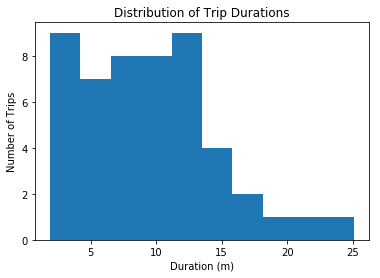

In [179]:
# load library
import matplotlib.pyplot as plt

%matplotlib inline 

# example histogram, data taken from bay area sample
data = [ 7.65,  8.92,  7.42,  5.50, 16.17,  4.20,  8.98,  9.62, 11.48, 14.33,
        19.02, 21.53,  3.90,  7.97,  2.62,  2.67,  3.08, 14.40, 12.90,  7.83,
        25.12,  8.30,  4.93, 12.43, 10.60,  6.17, 10.88,  4.78, 15.15,  3.53,
         9.43, 13.32, 11.72,  9.85,  5.22, 15.10,  3.95,  3.17,  8.78,  1.88,
         4.55, 12.68, 12.38,  9.78,  7.63,  6.45, 17.38, 11.90, 11.52,  8.63,]
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.ylabel('Number of Trips')
plt.show()

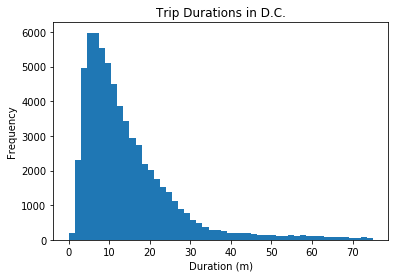

In [180]:
## Use this and additional cells to collect all of the trip times as a list ##
## and then use pyplot functions to generate a histogram of trip times.     ##
# load library
import matplotlib.pyplot as plt
%matplotlib inline 


#Read File
trip_times = pd.read_csv('./data/Washington-2016-Summary.csv')
#Put into data
data = (trip_times['duration'])
#Return data for plot



plt.hist(data, range=(0,75), bins=50)
plt.title('Trip Durations in D.C.')
plt.xlabel('Duration (m)')
plt.ylabel('Frequency')
plt.show()


Using the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers in your selected city. I will the same thing for only the Customers, adding limits to the plots so that only trips of duration less than 75 minutes are plotted. 

In analyzing the data below we see that for the customer group the 5 minute bin with the highest frequency of trips is the 15-20 minute range.  Likewise, for the subscriber group it is the 5-10 minute range.  For the subscriber graph we can see the peak in the graph in the 5-10 min range and the graph is postively skewed toward the left. We can also see a bigger tail off to the right of the peak where there is more frequency.   If we take a look at the customer graph the peak is at the 15-20 min range of trip duration with a slightly positive skew.  We also see a wider variety of trip durations than that of the subsriber group judging by the flatter the tails to the left and right of the peak.

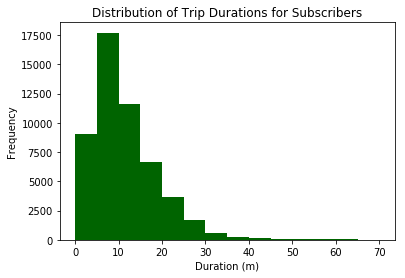

In [181]:
#limiting to only subscribers
subscribers = trip_times.query('user_type == "Subscriber"')
duration = subscribers['duration']
bins=np.arange(0,75,5)

plt.hist(duration, bins, color='darkgreen')
plt.title('Distribution of Trip Durations for Subscribers')
plt.xlabel('Duration (m)')
plt.ylabel('Frequency')
plt.show()


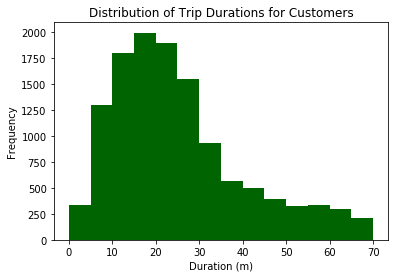

In [182]:
#limiting to only customers
subscribers = trip_times.query('user_type == "Customer"')
duration = subscribers['duration']
bins=np.arange(0,75,5)

plt.hist(duration, bins, color='darkgreen')
plt.title('Distribution of Trip Durations for Customers')
plt.xlabel('Duration (m)')
plt.ylabel('Frequency')
plt.show()


<a id='eda_continued'></a>
## Performing My Analysis on Trip Duration by Day

So far, I've performed an initial exploration into the data available. I have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these cities, I have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. 


Does the day of the week influence trip duration? Is there a difference between Customer and Subscribers in which day of the week influences trip duration the most in this city?


For Customers it is easy to see in the plots below that trip durations spike on the weekends, which is probably to be expected for one time users of the ride share system.  In all 3 cities for the user type of 'Customers' the longest trips are taken on Saturdays and Sundays.
For Subscribers however we seen another story.  In NYC and Chicago it is Wednesdays where it is observed that users take the longest trips and in both these cities as well we see Thursday being the day for the shortest trips. In Washington, however, we observe a similar pattern to that of the Customer user type where Saturdays and Sundays provide the longest trips.

This data begs the question as to what is driving the users to have shorter or longer trips on the observed days?  

In [183]:
## Use this and additional cells to continue to explore the dataset. ##
## Once you have performed your exploration, document your findings  ##
## in the Markdown cell above.                                       ##

def day_trends(path):
    """
    This functions calculates suscriber to customer ratio for each day of the week and returns a dictionary
    """
    #import dataframe and read csv
    data = pd.read_csv(path)
    
    #create dict
    dict_data = {'day': [],
                'subscribers': [],
                'customers': [],
                'avg_subscriber_duration': [],
                'avg_customer_duration': []}
    
    #fill dict
    for day in ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'):
        data2 = data[data['day_of_week']==day]
        
        #Calculating number customers and subscribers
        customers = len(data2[data2['user_type']=='Customer'])
        subscribers = len(data2[data2['user_type']=='Subscriber'])
        
        #Calculating avg duration of trips for both groups
        total_time_s = data2.query('user_type == "Subscriber"')
        avg_subscriber_duration = (np.sum(total_time_s['duration'])/subscribers)
        total_time_c = data2.query('user_type == "Customer"')
        avg_customer_duration = (np.sum(total_time_c['duration'])/customers)
        
        #Printing data to dictionary
        dict_data['day'].append(day)
        dict_data['subscribers'].append(subscribers)  
        dict_data['customers'].append(customers)     
        dict_data['avg_subscriber_duration'].append(round(avg_subscriber_duration,2))
        dict_data['avg_customer_duration'].append(round(avg_customer_duration,2))     
        
    return dict_data


#Test
print(day_trends('./data/Washington-2016-Summary.csv'))
print("\n")
print(day_trends('./data/NYC-2016-Summary.csv'))
print("\n")
print(day_trends('./data/Chicago-2016-Summary.csv'))


{'day': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 'subscribers': [7658, 8322, 8520, 8454, 7958, 5589, 5252], 'customers': [1736, 1426, 1583, 1530, 2012, 3311, 2975], 'avg_subscriber_duration': [12.31, 12.390000000000001, 12.56, 12.52, 12.17, 13.09, 12.949999999999999], 'avg_customer_duration': [40.75, 41.780000000000001, 36.369999999999997, 39.68, 40.719999999999999, 44.590000000000003, 43.43]}


{'day': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 'subscribers': [35623, 39487, 41403, 41197, 37606, 26126, 24454], 'customers': [3620, 2833, 3152, 3065, 3670, 7069, 6776], 'avg_subscriber_duration': [13.199999999999999, 12.9, 13.17, 13.289999999999999, 14.359999999999999, 14.83, 14.880000000000001], 'avg_customer_duration': [33.259999999999998, 33.439999999999998, 33.799999999999997, 31.390000000000001, 32.780000000000001, 33.219999999999999, 32.850000000000001]}


{'day': ['Monday', 'Tuesday', 'Wednesday', 'Thursday'

In [184]:
import matplotlib.pyplot as plt
def line_plt(dict, user_type, city):
    
    
    # Create Dataframe
    df = pd.DataFrame(dict)
    
    # Create plot
    %matplotlib inline
    if user_type == 'Customer':
        y=df['avg_subscriber_duration']
    else:
        y=df['avg_customer_duration']
    
    plt.plot(df['day'].index, y, 'g-', label = user_type)
    plt.xticks(np.arange(7), df['day'])
    plt.title('Distribution of '+user_type+ ' Trip Durations by Day in '+city)
    plt.xlabel('Days')
    plt.ylabel('Duration (mins)')
    plt.show()



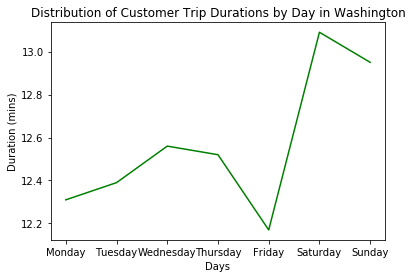

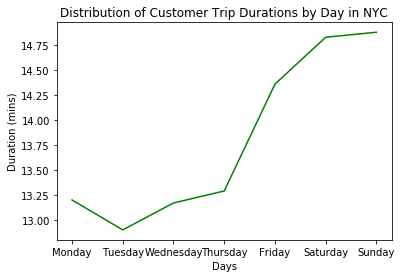

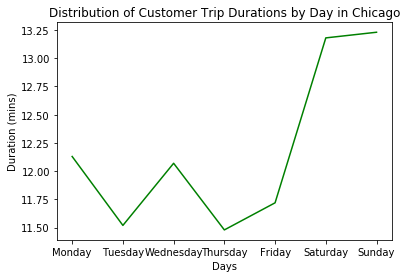

In [185]:
Washinton= day_trends('./data/Washington-2016-Summary.csv')
line_plt (Washinton, 'Customer', 'Washington')
NYC= day_trends('./data/NYC-2016-Summary.csv')
line_plt (NYC, 'Customer', 'NYC')
Chicago= day_trends('./data/Chicago-2016-Summary.csv')
line_plt (Chicago, 'Customer', 'Chicago')

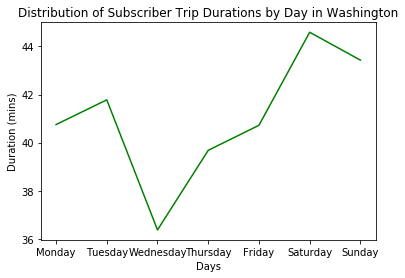

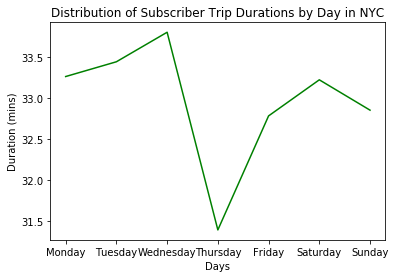

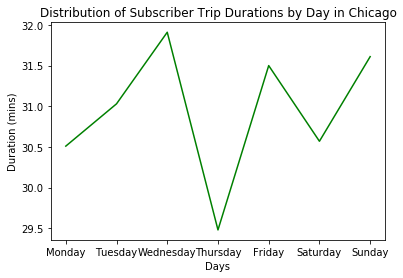

In [186]:
Washinton= day_trends('./data/Washington-2016-Summary.csv')
line_plt (Washinton, 'Subscriber', 'Washington')
NYC= day_trends('./data/NYC-2016-Summary.csv')
line_plt (NYC, 'Subscriber', 'NYC')
Chicago= day_trends('./data/Chicago-2016-Summary.csv')
line_plt (Chicago, 'Subscriber', 'Chicago')

<a id='conclusions'></a>
## Conclusions

This is only a sampling of the data analysis process: from generating questions, wrangling the data, and to exploring the data. Normally, at this point in the data analysis process, I wish I could someday draw conclusions about the data by performing a statistical test or fitting the data to a model for making predictions.

In [32]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Bike_Share_Analysis.ipynb'])

0